### Restricted Boltzmann Machine features for digit classification

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import minmax_scale
from sklearn.base import clone

In [2]:
# Setting up
def nudge_dataset(X, Y):

    #This produces a dataset 5 times bigger than the original one,by moving the 8x8 images in X around by 1px to left, right, down, up

    direction_vectors = [
    [[0, 1, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 1], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 1, 0]],
    ]

    def shift(x, w):
        return convolve(x.reshape((8, 8)), mode="constant", weights=w).ravel()

    X = np.concatenate( [X] + [np.apply_along_axis(shift, 1, X, vector) for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

In [3]:
# Load Data
X, y = datasets.load_digits(return_X_y=True)
X = np.asarray(X, "float32")
X, Y = nudge_dataset(X, y)
X = minmax_scale(X, feature_range=(0, 1)) # 0-1 scaling

In [4]:
#splitting into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [5]:
# Models we will use
logistic = linear_model.LogisticRegression(solver="newton-cg", tol=1)

rbm = BernoulliRBM(random_state=0, verbose=True)

rbm_features_classifier = Pipeline(steps=[("rbm", rbm),
("logistic", logistic)])

In [6]:
# Training Hyper-parameters. These were set by cross-validation, using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.06
rbm.n_iter = 10
# More components tend to give better prediction performance,but larger
# fitting time
rbm.n_components = 100
logistic.C = 6000

In [7]:
# Training RBM-Logistic Pipeline
rbm_features_classifier.fit(X_train, Y_train)
# Training the Logistic regression classifier directly on the pixel
raw_pixel_classifier = clone(logistic)
raw_pixel_classifier.C = 100.0
raw_pixel_classifier.fit(X_train, Y_train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -25.57, time = 0.07s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -23.68, time = 0.19s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -22.74, time = 0.17s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -21.92, time = 0.17s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -21.48, time = 0.15s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -21.07, time = 0.16s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -20.70, time = 0.12s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -20.65, time = 0.13s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -20.44, time = 0.11s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -20.13, time = 0.12s


LogisticRegression(C=100.0, solver='newton-cg', tol=1)

In [8]:
# Evaluation
Y_pred = rbm_features_classifier.predict(X_test)
print("Logistic regression using RBM features:\n%s\n" % (metrics.classification_report(Y_test, Y_pred)))

Y_pred = raw_pixel_classifier.predict(X_test)
print("Logistic regression using raw pixel features:\n%s\n"% (metrics.classification_report(Y_test, Y_pred))
)

Logistic regression using RBM features:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       174
           1       0.91      0.95      0.93       184
           2       0.95      0.95      0.95       166
           3       0.94      0.90      0.92       194
           4       0.96      0.94      0.95       186
           5       0.94      0.91      0.92       181
           6       0.98      0.97      0.97       207
           7       0.94      0.99      0.97       154
           8       0.88      0.88      0.88       182
           9       0.88      0.92      0.90       169

    accuracy                           0.94      1797
   macro avg       0.94      0.94      0.94      1797
weighted avg       0.94      0.94      0.94      1797


Logistic regression using raw pixel features:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       174
           1       0.60      0.58      0.59  

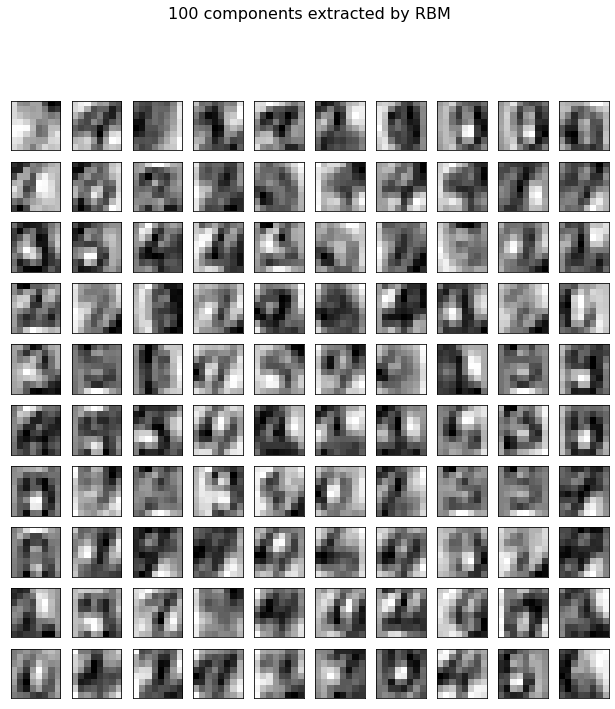

In [11]:
# Plotting
plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape((8, 8)), cmap=plt.cm.gray_r, interpolation="nearest")
    plt.xticks(())
    plt.yticks(())
plt.suptitle("100 components extracted by RBM", fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)
plt.show()
